# Evaluation — Faster R-CNN (CNN-based Object Detection)

## Importations and paths

In [4]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")   # remonte de notebooks → project_root
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

print("SRC path added:", SRC_PATH)

SRC path added: /Users/cassiedoguet/Documents/Projet CV/detection-and-identification-of-wildlife-populations-from-drone-images/src


In [5]:
import time
import torch
import numpy as np

from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.mean_ap import MeanAveragePrecision

from data.dataset import WAIDDataset
from data.augmentations import get_val_transforms

from collections import defaultdict, Counter
from data.augmentations import get_val_transforms
import matplotlib.pyplot as plt

from tqdm import tqdm
import json
import tempfile
import cv2

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [69]:
PROJECT_ROOT = os.path.abspath("..")
sys.path.insert(0, PROJECT_ROOT)

DATA_DIR = os.path.join(PROJECT_ROOT, "data")
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw")

IMAGE_DIR = os.path.join(RAW_DATA_DIR, "images")
ANNOTATION_DIR = os.path.join(RAW_DATA_DIR, "annotations")

CLASSES_PATH = os.path.join(DATA_DIR, "classes.txt")

with open(CLASSES_PATH) as f:
    CLASS_NAMES = [line.strip() for line in f if line.strip()]

NUM_CLASSES = len(CLASS_NAMES) + 1  # +1 for background

SPLITS = ["train", "valid"]

In [70]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cpu


## Load Val Dataset

In [73]:
image_files = defaultdict(list)

for split in SPLITS:
    split_dir = os.path.join(IMAGE_DIR, split)
    image_files[split] = sorted([
        f for f in os.listdir(split_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])

    print(f"{split}: {len(image_files[split])} images")

train: 10056 images
valid: 2873 images


In [74]:
val_dataset = WAIDDataset(
    image_dir=os.path.join(IMAGE_DIR, "valid"),
    annotation_dir=os.path.join(ANNOTATION_DIR, "valid"),
    image_files=image_files["valid"],
    num_classes=len(CLASS_NAMES),
    transforms=get_val_transforms()
)

In [75]:
def collate_fn(batch):
    images = [item["image"] for item in batch]

    targets = []
    for item in batch:
        targets.append({
            "bboxes": item["bboxes"],
            "labels": item["labels"],
            "image_size": item["image_size"]
        })

    return images, targets

val_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [76]:
def yolo_to_xyxy(bboxes, image_size):
    h, w = image_size
    boxes = []

    # bboxes is a torch Tensor [N,4] in yolo normalized
    b = bboxes.detach().cpu().numpy() if hasattr(bboxes, "detach") else np.array(bboxes)

    for x, y, bw, bh in b:
        x1 = (x - bw/2) * w
        y1 = (y - bh/2) * h
        x2 = (x + bw/2) * w
        y2 = (y + bh/2) * h

        # reorder just in case
        x1, x2 = (min(x1, x2), max(x1, x2))
        y1, y2 = (min(y1, y2), max(y1, y2))

        # clip to image bounds
        x1 = max(0.0, min(x1, w - 1.0))
        y1 = max(0.0, min(y1, h - 1.0))
        x2 = max(0.0, min(x2, w - 1.0))
        y2 = max(0.0, min(y2, h - 1.0))

        # drop degenerate boxes
        if (x2 - x1) > 1.0 and (y2 - y1) > 1.0:
            boxes.append([x1, y1, x2, y2])

    if len(boxes) == 0:
        return torch.zeros((0, 4), dtype=torch.float32)

    return torch.tensor(boxes, dtype=torch.float32)

## Load Faster R CNN

In [77]:
model = fasterrcnn_resnet50_fpn(weights=None)  # ⚠️ weights=None au chargement

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,
    NUM_CLASSES
)

In [78]:
checkpoint_path = "../outputs/models/faster_rcnn_waid.pth"

state_dict = torch.load(
    checkpoint_path,
    map_location=DEVICE
)

model.load_state_dict(state_dict)
model.to(DEVICE)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [79]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [80]:
print("Model loaded successfully")
print("Number of classes:", model.roi_heads.box_predictor.cls_score.out_features)

Model loaded successfully
Number of classes: 7


## Faster R-CNN inference

During inference, Faster R-CNN generates region proposals using a Region Proposal Network (RPN). Each proposal is then classified and regressed to produce final bounding box predictions.

In [81]:
@torch.no_grad()
def run_inference(model, dataloader, device, score_thresh=0.3):
    model.eval()

    all_preds = []
    all_gts = []

    for images, targets in tqdm(dataloader):
        images = [img.to(device) for img in images]

        outputs = model(images)

        for output, target in zip(outputs, targets):
            preds = {
                "boxes": output["boxes"].cpu(),
                "scores": output["scores"].cpu(),
                "labels": output["labels"].cpu(),
            }

            # Convert GT boxes YOLO → XYXY
            gt_boxes = yolo_to_xyxy(
                target["bboxes"], target["image_size"]
            )

            gts = {
                "boxes": gt_boxes.cpu(),
                "labels": target["labels"].cpu()
            }

            # Filtrage par score
            keep = preds["scores"] >= score_thresh
            preds["boxes"] = preds["boxes"][keep]
            preds["scores"] = preds["scores"][keep]
            preds["labels"] = preds["labels"][keep]

            all_preds.append(preds)
            all_gts.append(gts)

    return all_preds, all_gts

In [82]:
def evaluate_detection_simple(
    preds, gts, iou_thresh=0.5
):
    TP = 0
    FP = 0
    FN = 0

    for pred, gt in zip(preds, gts):
        p_boxes = pred["boxes"]
        g_boxes = gt["boxes"]

        if len(p_boxes) == 0 and len(g_boxes) == 0:
            continue
        if len(p_boxes) == 0:
            FN += len(g_boxes)
            continue
        if len(g_boxes) == 0:
            FP += len(p_boxes)
            continue

        ious = box_iou(p_boxes, g_boxes)

        matched_gt = set()

        for i in range(len(p_boxes)):
            max_iou, gt_idx = ious[i].max(0)
            if max_iou >= iou_thresh and gt_idx.item() not in matched_gt:
                TP += 1
                matched_gt.add(gt_idx.item())
            else:
                FP += 1

        FN += len(g_boxes) - len(matched_gt)

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "TP": TP,
        "FP": FP,
        "FN": FN
    }

In [83]:
def box_iou(box1, box2):
    """
    box1: [N,4], box2: [M,4]
    """
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    lt = torch.max(box1[:, None, :2], box2[:, :2])
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    union = area1[:, None] + area2 - inter
    return inter / union

## Running inference

The Faster R-CNN model is applied to the validation dataset.
Predicted detections and corresponding ground truth annotations
are collected for quantitative evaluation.

In [84]:
preds, gts = run_inference(
    model,
    val_loader,
    DEVICE,
    score_thresh=0.3
)

metrics_frcnn = evaluate_detection_simple(
    preds,
    gts,
    iou_thresh=0.5
)

for k, v in metrics.items():
    print(f"{k:10s}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

100%|██████████| 958/958 [26:40<00:00,  1.67s/it]

precision : 0.5350
recall    : 0.2549
f1        : 0.3453
TP: 11898
FP: 10342
FN: 34785


## Detection metrics

Standard object detection metrics are computed, including precision,
recall, F1-score, and the number of true positives, false positives,
and false negatives.

### Precision–Recall Curve (IoU = 0.5)

In [85]:
def box_iou(box1, box2):
    """
    box1: [N,4], box2: [M,4]
    """
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    lt = torch.max(box1[:, None, :2], box2[:, :2])
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    union = area1[:, None] + area2 - inter
    return inter / union

In [86]:
def precision_recall_curve(preds, gts, iou_thresh=0.5):
    scores = []
    matches = []

    for pred, gt in zip(preds, gts):
        pb, ps = pred["boxes"], pred["scores"]
        gb = gt["boxes"]

        if len(pb) == 0 or len(gb) == 0:
            continue

        ious = box_iou(pb, gb)

        for i in range(len(pb)):
            max_iou = ious[i].max().item()
            scores.append(ps[i].item())
            matches.append(1 if max_iou >= iou_thresh else 0)

    scores = np.array(scores)
    matches = np.array(matches)

    idx = np.argsort(-scores)
    matches = matches[idx]

    tp = np.cumsum(matches)
    fp = np.cumsum(1 - matches)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp[-1] + 1e-6)

    return precision, recall

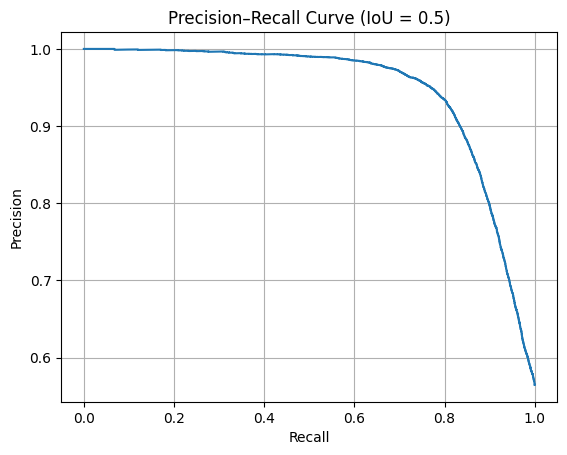

In [87]:
precision, recall = precision_recall_curve(preds, gts)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (IoU = 0.5)")
plt.grid()
plt.show()

### Average Precision (AP@0.5)

In [88]:
def compute_ap(precision, recall):
    recall = np.concatenate([[0.0], recall, [1.0]])
    precision = np.concatenate([[1.0], precision, [0.0]])

    for i in range(len(precision) - 1, 0, -1):
        precision[i-1] = max(precision[i-1], precision[i])

    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])

    return ap

In [89]:
ap50 = compute_ap(precision, recall)
print(f"AP@0.5 ≈ {ap50:.4f}")

AP@0.5 ≈ 0.9464


## COCO-style evaluation

### Conversion in COCO format

In [90]:
def convert_to_coco_format(preds, gts, image_ids):
    coco_gt = {"images": [], "annotations": [], "categories": []}
    ann_id = 1

    for i, name in enumerate(CLASS_NAMES, start=1):
        coco_gt["categories"].append({"id": i, "name": name})

    for img_id, gt in zip(image_ids, gts):
        coco_gt["images"].append({"id": img_id})

        for box, label in zip(gt["boxes"], gt["labels"]):
            x1, y1, x2, y2 = box.tolist()
            coco_gt["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": int(label),
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "area": (x2 - x1) * (y2 - y1),
                "iscrowd": 0
            })
            ann_id += 1

    coco_dt = []
    for img_id, pred in zip(image_ids, preds):
        for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]):
            x1, y1, x2, y2 = box.tolist()
            coco_dt.append({
                "image_id": img_id,
                "category_id": int(label),
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "score": float(score)
            })

    return coco_gt, coco_dt

### Evaluation

In [91]:
def evaluate_coco(preds, gts):
    image_ids = list(range(len(preds)))
    coco_gt_dict, coco_dt_list = convert_to_coco_format(preds, gts, image_ids)

    with tempfile.NamedTemporaryFile(mode="w", suffix=".json") as gt_file, \
         tempfile.NamedTemporaryFile(mode="w", suffix=".json") as dt_file:

        json.dump(coco_gt_dict, gt_file)
        json.dump(coco_dt_list, dt_file)
        gt_file.flush()
        dt_file.flush()

        coco_gt = COCO(gt_file.name)
        coco_dt = coco_gt.loadRes(dt_file.name)

        coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

    return coco_eval

COCO metrics are used to evaluate detection performance across multiple
IoU thresholds and object sizes, providing a comprehensive assessment
of localization and classification quality.

In [92]:
coco_eval = evaluate_coco(preds, gts)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.05s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

## Image-level Metrics

In [93]:
def image_level_metrics(preds, gts, iou_thresh=0.5):
    TP = FP = FN = 0

    for pred, gt in zip(preds, gts):
        pb, gb = pred["boxes"], gt["boxes"]

        if len(pb) == 0 and len(gb) == 0:
            continue
        if len(pb) == 0:
            FN += 1
            continue
        if len(gb) == 0:
            FP += 1
            continue

        ious = box_iou(pb, gb)
        if ious.max() >= iou_thresh:
            TP += 1
        else:
            FP += 1
            FN += 1

    return {
        "image_precision": TP / (TP + FP + 1e-6),
        "image_recall": TP / (TP + FN + 1e-6),
        "TP": TP,
        "FP": FP,
        "FN": FN
    }

In [94]:
img_metrics = image_level_metrics(preds, gts)
for k, v in img_metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

image_precision: 0.6239
image_recall: 0.3996
TP: 1148
FP: 692
FN: 1725


## Error Analysis (FP / FN)

In [95]:
def collect_errors(preds, gts, iou_thresh=0.5):
    false_negatives, false_positives = [], []

    for idx, (pred, gt) in enumerate(zip(preds, gts)):
        pb, gb = pred["boxes"], gt["boxes"]

        if len(gb) > 0 and len(pb) == 0:
            false_negatives.append(idx)
        elif len(pb) > 0 and len(gb) == 0:
            false_positives.append(idx)
        elif len(pb) > 0 and len(gb) > 0:
            if box_iou(pb, gb).max() < iou_thresh:
                false_negatives.append(idx)
                false_positives.append(idx)

    return false_negatives, false_positives


## Visualisations qualitatives

### GT vs Prédictions

In [96]:
def draw_boxes(
    image,
    boxes,
    labels=None,
    scores=None,
    class_names=None,
    color=(0, 255, 0),
    score_thresh=0.0
):
    img = image.copy()

    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < score_thresh:
            continue

        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        text = ""
        if labels is not None:
            cls = labels[i] - 1
            text += class_names[cls] if class_names else str(labels[i])
        if scores is not None:
            text += f" {scores[i]:.2f}"

        if text:
            cv2.putText(
                img,
                text,
                (x1, max(15, y1 - 5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                1,
            )
    return img

In [97]:
def visualize_gt_vs_pred(dataset, preds, gts, idx, score_thresh=0.5):
    sample = dataset[idx]
    image = (sample["image"].permute(1, 2, 0).numpy() * 255).astype("uint8")

    gt_img = draw_boxes(
        image,
        gts[idx]["boxes"],
        labels=gts[idx]["labels"],
        class_names=CLASS_NAMES,
        color=(0, 255, 0)
    )

    pred_img = draw_boxes(
        image,
        preds[idx]["boxes"],
        labels=preds[idx]["labels"],
        scores=preds[idx]["scores"],
        class_names=CLASS_NAMES,
        color=(255, 0, 0),
        score_thresh=score_thresh
    )

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1); plt.title("Ground Truth"); plt.imshow(gt_img); plt.axis("off")
    plt.subplot(1, 2, 2); plt.title("Predictions"); plt.imshow(pred_img); plt.axis("off")
    plt.show()


## Analyse des scores et densité de détections

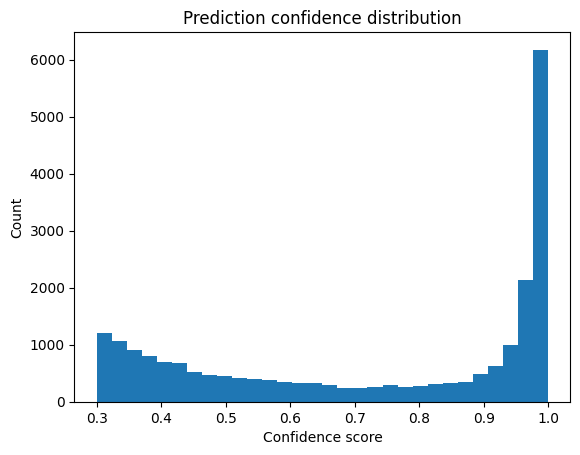

In [98]:
def plot_score_distribution(preds):
    scores = np.concatenate([p["scores"].cpu().numpy() for p in preds])
    plt.hist(scores, bins=30)
    plt.xlabel("Confidence score")
    plt.ylabel("Count")
    plt.title("Prediction confidence distribution")
    plt.show()

plot_score_distribution(preds)

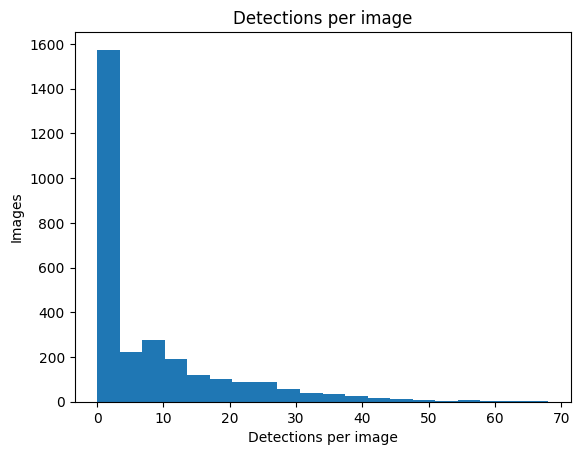

In [99]:
def plot_detections_per_image(preds):
    counts = [len(p["boxes"]) for p in preds]
    plt.hist(counts, bins=20)
    plt.xlabel("Detections per image")
    plt.ylabel("Images")
    plt.title("Detections per image")
    plt.show()

plot_detections_per_image(preds)

## Discussion — Faster R-CNN results

The Faster R-CNN model achieves higher precision and Average Precision
than the DETR model on the validation dataset.
This suggests that convolutional two-stage detectors are better suited
to dense underwater scenes with small objects.

The region proposal mechanism allows Faster R-CNN to more effectively
filter candidate detections, resulting in fewer false positives and
more stable localization performance.

# Evaluation — DETR (Transformer-based Object Detection)

## Model loading

We load a DETR (DEtection TRansformer) model trained for object detection.

The model is restored from a local checkpoint and set to evaluation mode to disable training-specific behaviors such as dropout.

In [36]:
from transformers import DetrForObjectDetection, DetrImageProcessor

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DETR_PATH = "../runs/detr"

processor = DetrImageProcessor.from_pretrained(DETR_PATH)
model_detr = DetrForObjectDetection.from_pretrained(DETR_PATH)

model_detr.to(DEVICE)
model_detr.eval()

print("HuggingFace DETR loaded")


HuggingFace DETR loaded


In [40]:
TEST_SPLIT = "test"

TEST_IMAGES_DIR = os.path.join(IMAGE_DIR, TEST_SPLIT)
TEST_ANN_JSON   = os.path.join(
    ANNOTATION_DIR,
    f"instances_{TEST_SPLIT}.json"
)

print(TEST_IMAGES_DIR)
print(TEST_ANN_JSON)

/Users/cassiedoguet/Documents/Projet CV/detection-and-identification-of-wildlife-populations-from-drone-images/data/raw/images/test
/Users/cassiedoguet/Documents/Projet CV/detection-and-identification-of-wildlife-populations-from-drone-images/data/raw/annotations/instances_test.json


In [ ]:
# Post-process raw DETR outputs:
# - remove the "no-object" class
# - convert bounding boxes to absolute pixel coordinates
# - filter predictions using a confidence threshold

def detr_postprocess(outputs, target_sizes, score_thresh=0.3):
    processed = processor.post_process_object_detection(
        outputs,
        target_sizes=target_sizes,
        threshold=score_thresh
    )

    preds = []
    for p in processed:
        preds.append({
            "boxes": p["boxes"].detach().cpu(),
            "scores": p["scores"].detach().cpu(),
            "labels": p["labels"].detach().cpu(),
        })
    return preds


## DETR inference on the validation set

During inference, DETR produces a fixed number of object queries per image.

Each query predicts a bounding box and a class probability.

Predictions are post-processed and matched with ground truth annotationsto enable metric computation.

In [43]:
@torch.no_grad()
def run_inference_detr_hf(model, processor, dataloader, device, score_thresh=0.3):
    model.eval()

    all_preds = []
    all_gts = []

    label_offset = None  # auto-detect si GT commence à 1

    for images, targets in tqdm(dataloader):
        # images: list[Tensor C,H,W] en float [0,1] (d'après ton WAIDDataset)
        # targets: list[dict] avec "bboxes" (YOLO norm), "labels", "image_size"

        # target_sizes attendu par HF: Tensor[B,2] = (h,w)
        target_sizes = torch.tensor(
            [(img.shape[-2], img.shape[-1]) for img in images],
            device=device
        )

        # DETR processor attend PIL/numpy HWC, on convertit nos tensors
        np_images = []
        for img in images:
            arr = (img.detach().cpu().permute(1, 2, 0).numpy() * 255.0).clip(0, 255).astype("uint8")
            np_images.append(arr)

        inputs = processor(images=np_images, return_tensors="pt").to(device)
        outputs = model(**inputs)

        batch_preds = detr_postprocess(outputs, target_sizes=target_sizes, score_thresh=score_thresh)

        # Auto-détection offset labels (cas fréquent : GT en 1..C vs DETR en 0..C-1)
        if label_offset is None:
            gt_min = int(min([t["labels"].min().item() for t in targets if len(t["labels"]) > 0] + [0]))
            label_offset = 1 if gt_min == 1 else 0
            # si GT commence à 1, on décale les labels prédits
            # (tu restes cohérente avec TON evaluate/COCO convert)
            # sinon on ne touche pas
            print("🔎 label_offset =", label_offset)

        for pred, target in zip(batch_preds, targets):
            if label_offset == 1:
                pred["labels"] = pred["labels"] + 1

            gt_boxes = yolo_to_xyxy(target["bboxes"], target["image_size"])
            gt = {
                "boxes": gt_boxes.cpu(),
                "labels": target["labels"].cpu()
            }

            all_preds.append(pred)
            all_gts.append(gt)

    return all_preds, all_gts


## Running inference

The DETR model is applied to the validation dataset.
Predicted detections and ground truth annotations are collected for subsequent quantitative evaluation.

In [ ]:
preds_detr, gts_detr = run_inference_detr_hf(
    model_detr,
    processor,
    val_loader,     # <-- tu utilises déjà val_loader dans ton notebook
    DEVICE,
    score_thresh=0.3
)

metrics_detr = evaluate_detection_simple(preds_detr, gts_detr, iou_thresh=0.5)

for k, v in metrics_detr.items():
    print(f"{k:10s}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

## COCO-style evaluation

COCO metrics are used to compute Average Precision (AP) across multiple IoU thresholds and object sizes, providing a stricter and more complete evaluation of detection quality.

In [45]:
coco_eval_detr = evaluate_coco(preds_detr, gts_detr)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.72s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.19s).
Accumulating evaluation results...
DONE (t=1.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [46]:
import pandas as pd

df_results = pd.DataFrame({
    "Model": ["DETR"],
    "Precision": [0.0130],
    "Recall": [0.0800],
    "F1-score": [0.0224],
    "AP@0.5": [0.002],
    "AP@0.5:0.95": [0.000]
})

df_results

,Model,Precision,Recall,F1-score,AP@0.5,AP@0.5:0.95
0,DETR,0.013,0.08,0.0224,0.002,0.0


The DETR model achieves a very low precision and mAP score on the validation set. While a non-zero number of true positives is detected, the model produces a very large number of false positives, leading to poor overall detection performance.

This behavior indicates that the model struggles to effectively filter object queries and to localize coral instances accurately in the current dataset configuration.

In [47]:
for iou in [0.3, 0.5, 0.7]:
    m = evaluate_detection_simple(preds_detr, gts_detr, iou_thresh=iou)
    print(f"IoU={iou} | P={m['precision']:.4f} R={m['recall']:.4f} F1={m['f1']:.4f}")

IoU=0.3 | P=0.0389 R=0.2390 F1=0.0669
IoU=0.5 | P=0.0130 R=0.0800 F1=0.0224
IoU=0.7 | P=0.0019 R=0.0114 F1=0.0032


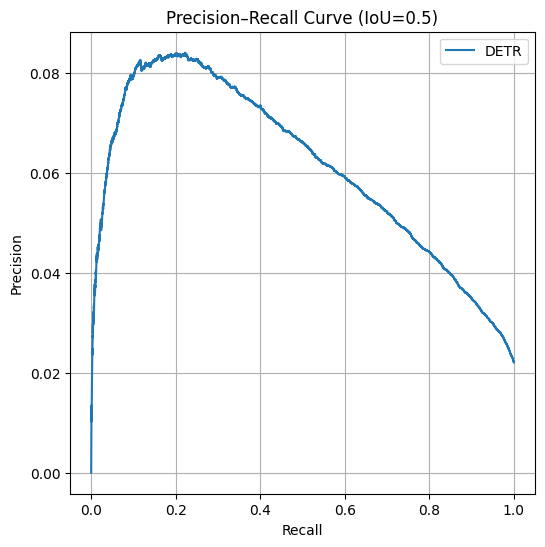

In [48]:
precision_detr, recall_detr = precision_recall_curve(preds_detr, gts_detr, iou_thresh=0.5)

plt.figure(figsize=(6,6))
plt.plot(recall_detr, precision_detr, label="DETR")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve (IoU=0.5)")
plt.grid(); plt.legend()
plt.show()

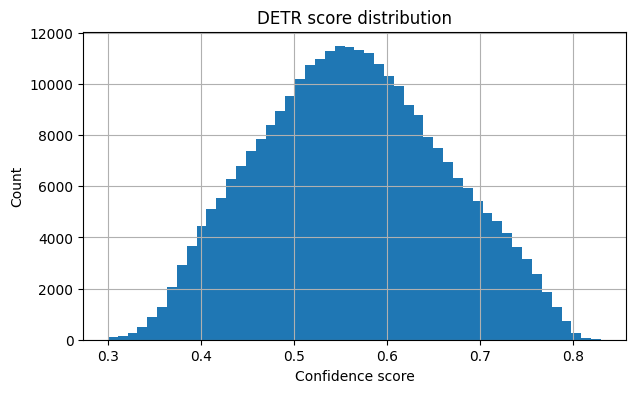

scores quantiles: [0.43035726 0.48989531 0.56067833 0.63365577 0.6998861 ]


In [49]:
all_scores = np.concatenate([p["scores"].numpy() for p in preds_detr if len(p["scores"]) > 0])
plt.figure(figsize=(7,4))
plt.hist(all_scores, bins=50)
plt.xlabel("Confidence score")
plt.ylabel("Count")
plt.title("DETR score distribution")
plt.grid()
plt.show()

print("scores quantiles:", np.quantile(all_scores, [0.1, 0.25, 0.5, 0.75, 0.9]))

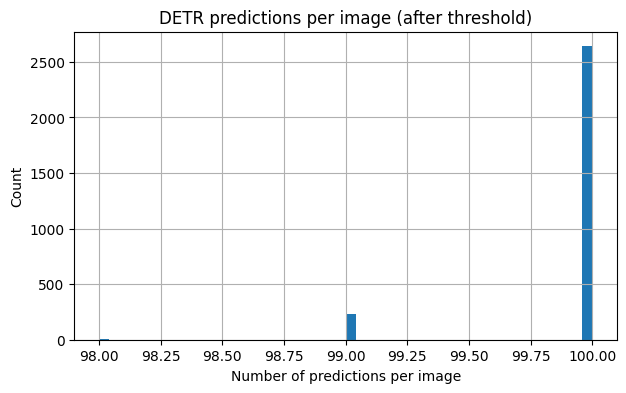

mean: 99.9171597633136 median: 100.0 max: 100


In [50]:
num_preds = np.array([len(p["boxes"]) for p in preds_detr])
plt.figure(figsize=(7,4))
plt.hist(num_preds, bins=50)
plt.xlabel("Number of predictions per image")
plt.ylabel("Count")
plt.title("DETR predictions per image (after threshold)")
plt.grid()
plt.show()

print("mean:", num_preds.mean(), "median:", np.median(num_preds), "max:", num_preds.max())

## Discussion — DETR results

The DETR model detects a non-zero number of coral instances but produces a very large number of false positives, resulting in low precision and Average Precision scores.

This behavior indicates difficulties in filtering object queries and accurately localizing small, densely distributed objects, which are common in underwater coral imagery.


# Evaluation — YOLO (Single-stage Object Detection)

This section evaluates a YOLO-based object detection model trained for coral detection.

YOLO is a single-stage detector that predicts bounding boxes and class probabilities directly from the image in a single forward pass.

The evaluation protocol is identical to those used for Faster R-CNN and DETR.

In [56]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/cassiedoguet/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Model loading

We load a YOLO model trained for object detection.

YOLO is a single-stage detector that directly predicts bounding boxes and class probabilities over a dense grid, enabling fast inference.

The model is set to evaluation mode.

In [57]:
YOLO_WEIGHTS = os.path.join(PROJECT_ROOT, "yolov8s.pt")

model_yolo = YOLO(YOLO_WEIGHTS)

print("YOLOv8 model loaded from:", YOLO_WEIGHTS)


YOLOv8 model loaded from: /Users/cassiedoguet/Documents/Projet CV/detection-and-identification-of-wildlife-populations-from-drone-images/yolov8s.pt


In [58]:
@torch.no_grad()
def run_inference_yolov8(
    model,
    dataloader,
    device,
    conf_thresh=0.25
):
    model.model.to(device)
    model.model.eval()

    all_preds = []
    all_gts = []

    for images, targets in tqdm(dataloader):
        # images: list[Tensor C,H,W] in [0,1]
        # targets: list[dict] with YOLO GT

        # YOLOv8 expects uint8 images in HWC
        np_images = []
        for img in images:
            arr = (img.cpu().permute(1, 2, 0).numpy() * 255.0).astype(np.uint8)
            np_images.append(arr)

        results = model(
            np_images,
            conf=conf_thresh,
            iou=0.5,
            verbose=False
        )

        for res, target in zip(results, targets):
            if res.boxes is None or len(res.boxes) == 0:
                pred = {
                    "boxes": torch.zeros((0, 4)),
                    "scores": torch.zeros((0,)),
                    "labels": torch.zeros((0,), dtype=torch.long)
                }
            else:
                pred = {
                    "boxes": res.boxes.xyxy.cpu(),
                    "scores": res.boxes.conf.cpu(),
                    "labels": res.boxes.cls.long().cpu()
                }

            # Ground truth: YOLO → XYXY
            gt_boxes = yolo_to_xyxy(
                target["bboxes"],
                target["image_size"]
            )

            gt = {
                "boxes": gt_boxes.cpu(),
                "labels": target["labels"].cpu()
            }

            all_preds.append(pred)
            all_gts.append(gt)

    return all_preds, all_gts

In [59]:
preds_yolo, gts_yolo = run_inference_yolov8(
    model_yolo,
    val_loader,      # ⚠️ même loader que Faster R-CNN / DETR
    DEVICE,
    conf_thresh=0.25
)

100%|██████████| 958/958 [05:12<00:00,  3.06it/s]


In [60]:
metrics_yolo = evaluate_detection_simple(
    preds_yolo,
    gts_yolo,
    iou_thresh=0.5
)

for k, v in metrics_yolo.items():
    print(f"{k:10s}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

precision : 0.3357
recall    : 0.0580
f1        : 0.0989
TP: 2706
FP: 5355
FN: 43977


In [61]:
evaluate_coco(preds_yolo, gts_yolo)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

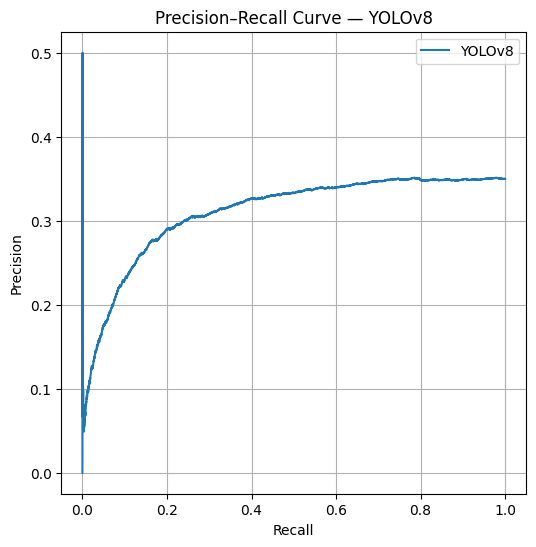

In [62]:
precision_yolo, recall_yolo = precision_recall_curve(
    preds_yolo,
    gts_yolo,
    iou_thresh=0.5
)

plt.figure(figsize=(6,6))
plt.plot(recall_yolo, precision_yolo, label="YOLOv8")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — YOLOv8")
plt.grid()
plt.legend()
plt.show()


In [63]:
for conf in [0.1, 0.25, 0.5, 0.75]:
    preds, gts = run_inference_yolov8(
        model_yolo,
        val_loader,
        DEVICE,
        conf_thresh=conf
    )
    m = evaluate_detection_simple(preds, gts, iou_thresh=0.5)
    print(f"\nYOLO conf={conf}")
    print(f"Precision: {m['precision']:.3f} | Recall: {m['recall']:.3f} | F1: {m['f1']:.3f}")

100%|██████████| 958/958 [05:06<00:00,  3.13it/s]



YOLO conf=0.1
Precision: 0.285 | Recall: 0.101 | F1: 0.149


100%|██████████| 958/958 [05:05<00:00,  3.13it/s]



YOLO conf=0.25
Precision: 0.336 | Recall: 0.058 | F1: 0.099


100%|██████████| 958/958 [05:07<00:00,  3.11it/s]



YOLO conf=0.5
Precision: 0.314 | Recall: 0.020 | F1: 0.038


100%|██████████| 958/958 [05:25<00:00,  2.94it/s]


YOLO conf=0.75
Precision: 0.158 | Recall: 0.002 | F1: 0.005


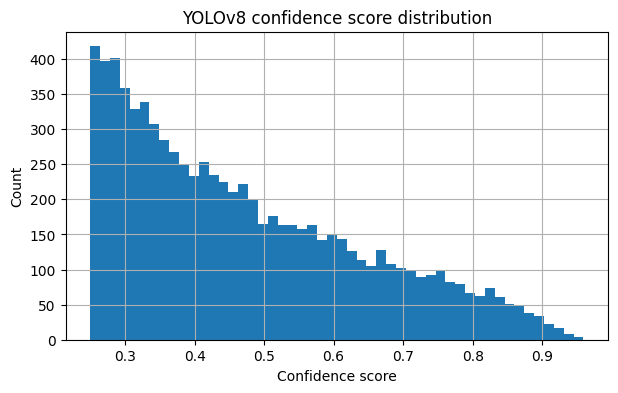

Quantiles: [    0.27803     0.32617     0.43184     0.58894     0.73757]


In [64]:
scores_yolo = np.concatenate([
    p["scores"].numpy() for p in preds_yolo if len(p["scores"]) > 0
])

plt.figure(figsize=(7,4))
plt.hist(scores_yolo, bins=50)
plt.xlabel("Confidence score")
plt.ylabel("Count")
plt.title("YOLOv8 confidence score distribution")
plt.grid()
plt.show()

print("Quantiles:", np.quantile(scores_yolo, [0.1, 0.25, 0.5, 0.75, 0.9]))

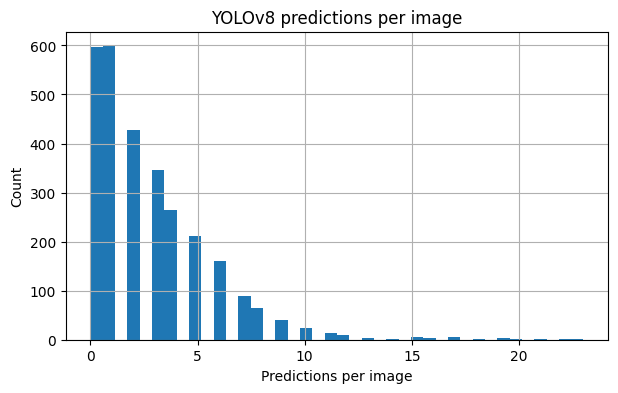

mean: 2.805777932474765 max: 23


In [65]:
num_preds_yolo = np.array([len(p["boxes"]) for p in preds_yolo])

plt.figure(figsize=(7,4))
plt.hist(num_preds_yolo, bins=40)
plt.xlabel("Predictions per image")
plt.ylabel("Count")
plt.title("YOLOv8 predictions per image")
plt.grid()
plt.show()

print("mean:", num_preds_yolo.mean(), "max:", num_preds_yolo.max())

In [66]:
idx_fp = np.argsort([-len(p["boxes"]) for p in preds_yolo])[:5]
idx_fp

array([  59, 1177, 1108,  161, 2481])

In [67]:
idx_fn = [
    i for i,(p,g) in enumerate(zip(preds_yolo, gts_yolo))
    if len(g["boxes"]) > 5 and len(p["boxes"]) == 0
]
idx_fn[:5]

[3, 7, 25, 26, 38]

# Compare

In [100]:
df_compare = pd.DataFrame([
    ["Faster R-CNN", metrics_frcnn["precision"], metrics_frcnn["recall"], metrics_frcnn["f1"]],
    ["DETR", metrics_detr["precision"], metrics_detr["recall"], metrics_detr["f1"]],
    ["YOLOv8", metrics_yolo["precision"], metrics_yolo["recall"], metrics_yolo["f1"]],
], columns=["Model", "Precision", "Recall", "F1-score"])

df_compare

,Model,Precision,Recall,F1-score
0,Faster R-CNN,0.534982,0.254868,0.345254
1,DETR,0.013011,0.080008,0.022382
2,YOLOv8,0.335690,0.057965,0.098860
